<a href="https://colab.research.google.com/github/EVA4-RS-Group/Phase2/blob/master/S8/SR_GAN/SR_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Oct  9 16:23:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import argparse
import os
from math import log10

import pandas as pd
import torch.optim as optim
import torch.utils.data
import torchvision.utils as utils
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm

import pytorch_ssim
from data_utils import TrainDatasetFromFolder, ValDatasetFromFolder, display_transform
from loss import GeneratorLoss
from model import Generator, Discriminator

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r "/content/drive/My Drive/Phase2_S2/S8/data.zip" "/content/"
!unzip "data.zip"
!rm -rf "data.zip"
!mkdir epochs
!mkdir statistics

Archive:  data.zip
   creating: data/
  inflating: data/desktop.ini        
   creating: data/test/
  inflating: data/test/000_1AB0W8.jpg  
  inflating: data/test/009ecd14a176aadfff8fcb2f8c8cec00e0baf9f7c17172e6ea16a0d8d787.jpg  
  inflating: data/test/09dff222d763d10bebcde24c519bae81.jpg  
  inflating: data/test/10-Famous-Actors-Who-Are-Unrecognizable-Now.jpg  
  inflating: data/test/12Cute-Puppies--564x460.jpg  
  inflating: data/test/142413-obccnqiooh-1591266679.jpg  
  inflating: data/test/1433261929-25-toughest-animals-lede.jpg  
  inflating: data/test/1581656428_503_Forbes-has-Released-The-list-of-World-Famous-10-Highest.jpg  
  inflating: data/test/170621-Puppy-Thumb.jpg  
  inflating: data/test/19562453_303.jpg  
  inflating: data/test/2-covid.jpg   
  inflating: data/test/2.-Leonardo-DiCaprio_2.jpg  
  inflating: data/test/2020-2-10-lion_roar_africa_cropped.jpg  
  inflating: data/test/22627e51c24ecf51ce9d3312896d7e88.jpg  
  inflating: data/test/236742-1600x1030-cutest-puppy-

In [ ]:
CROP_SIZE = 88 #opt.crop_size
UPSCALE_FACTOR = 4 #opt.upscale_factor
NUM_EPOCHS = 200 #opt.num_epochs

In [ ]:
train_set = TrainDatasetFromFolder('data/train', crop_size=CROP_SIZE, upscale_factor=UPSCALE_FACTOR)
val_set = ValDatasetFromFolder('data/test', upscale_factor=UPSCALE_FACTOR)
train_loader = DataLoader(dataset=train_set, num_workers=4, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_set, num_workers=4, batch_size=1, shuffle=False)

In [ ]:
netG = Generator(UPSCALE_FACTOR)
print('# generator parameters:', sum(param.numel() for param in netG.parameters()))
netD = Discriminator()
print('# discriminator parameters:', sum(param.numel() for param in netD.parameters()))

generator_criterion = GeneratorLoss()

if torch.cuda.is_available():
    netG.cuda()
    netD.cuda()
    generator_criterion.cuda()

optimizerG = optim.Adam(netG.parameters())
optimizerD = optim.Adam(netD.parameters())

# generator parameters: 734219
# discriminator parameters: 5215425


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': []}

for epoch in range(1, NUM_EPOCHS + 1):
    train_bar = tqdm(train_loader)
    running_results = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}

    netG.train()
    netD.train()
    for data, target in train_bar:
        g_update_first = True
        batch_size = data.size(0)
        running_results['batch_sizes'] += batch_size

        ############################
        # (1) Update D network: maximize D(x)-1-D(G(z))
        ###########################
        real_img = Variable(target)
        if torch.cuda.is_available():
            real_img = real_img.cuda()
        z = Variable(data)
        if torch.cuda.is_available():
            z = z.cuda()
        fake_img = netG(z)

        netD.zero_grad()
        real_out = netD(real_img).mean()
        fake_out = netD(fake_img).mean()
        d_loss = 1 - real_out + fake_out
        d_loss.backward(retain_graph=True)
        optimizerD.step()

        ############################
        # (2) Update G network: minimize 1-D(G(z)) + Perception Loss + Image Loss + TV Loss
        ###########################
        netG.zero_grad()
        fake_img = netG(z)# added
        fake_out = netD(fake_img).mean()# added
        g_loss = generator_criterion(fake_out, fake_img, real_img)
        g_loss.backward()
        
        fake_img = netG(z)
        fake_out = netD(fake_img).mean()
        
        
        optimizerG.step()

        # loss for current batch before optimization 
        running_results['g_loss'] += g_loss.item() * batch_size
        running_results['d_loss'] += d_loss.item() * batch_size
        running_results['d_score'] += real_out.item() * batch_size
        running_results['g_score'] += fake_out.item() * batch_size

        train_bar.set_description(desc='[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f' % (
            epoch, NUM_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
            running_results['g_loss'] / running_results['batch_sizes'],
            running_results['d_score'] / running_results['batch_sizes'],
            running_results['g_score'] / running_results['batch_sizes']))

    netG.eval()
    out_path = 'training_results/SRF_' + str(UPSCALE_FACTOR) + '/'
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    
    with torch.no_grad():
        val_bar = tqdm(val_loader)
        valing_results = {'mse': 0, 'ssims': 0, 'psnr': 0, 'ssim': 0, 'batch_sizes': 0}
        val_images = []
        for val_lr, val_hr_restore, val_hr in val_bar:
            batch_size = val_lr.size(0)
            valing_results['batch_sizes'] += batch_size
            lr = val_lr
            hr = val_hr
            if torch.cuda.is_available():
                lr = lr.cuda()
                hr = hr.cuda()
            sr = netG(lr)
    
            batch_mse = ((sr - hr) ** 2).data.mean()
            valing_results['mse'] += batch_mse * batch_size
            batch_ssim = pytorch_ssim.ssim(sr, hr).item()
            valing_results['ssims'] += batch_ssim * batch_size
            valing_results['psnr'] = 10 * log10((hr.max()**2) / (valing_results['mse'] / valing_results['batch_sizes']))
            valing_results['ssim'] = valing_results['ssims'] / valing_results['batch_sizes']
            val_bar.set_description(
                desc='[converting LR images to SR images] PSNR: %.4f dB SSIM: %.4f' % (
                    valing_results['psnr'], valing_results['ssim']))
    
            val_images.extend(
                [display_transform()(val_hr_restore.squeeze(0)), display_transform()(hr.data.cpu().squeeze(0)),
                 display_transform()(sr.data.cpu().squeeze(0))])
        val_images = torch.stack(val_images)
        val_images = torch.chunk(val_images, val_images.size(0) // 15)
        val_save_bar = tqdm(val_images, desc='[saving training results]')
        index = 1
        # if(epoch%50 == 0 and epoch!=0):
        for image in val_save_bar:
            image = utils.make_grid(image, nrow=3, padding=5)
            utils.save_image(image, out_path + 'epoch_%d_index_%d.png' % (epoch, index), padding=5)
            index += 1

    # save model parameters
    if (epoch%100 ==0 and epoch != 0):
      torch.save(netG.state_dict(), 'epochs/netG_epoch_%d_%d.pth' % (UPSCALE_FACTOR, epoch))
      torch.save(netD.state_dict(), 'epochs/netD_epoch_%d_%d.pth' % (UPSCALE_FACTOR, epoch))
    # save loss\scores\psnr\ssim
    results['d_loss'].append(running_results['d_loss'] / running_results['batch_sizes'])
    results['g_loss'].append(running_results['g_loss'] / running_results['batch_sizes'])
    results['d_score'].append(running_results['d_score'] / running_results['batch_sizes'])
    results['g_score'].append(running_results['g_score'] / running_results['batch_sizes'])
    results['psnr'].append(valing_results['psnr'])
    results['ssim'].append(valing_results['ssim'])

    if epoch % 10 == 0 and epoch != 0:
        out_path = 'statistics/'
        data_frame = pd.DataFrame(
            data={'Loss_D': results['d_loss'], 'Loss_G': results['g_loss'], 'Score_D': results['d_score'],
                  'Score_G': results['g_score'], 'PSNR': results['psnr'], 'SSIM': results['ssim']},
            index=range(1, epoch + 1))
        data_frame.to_csv(out_path + 'srf_' + str(UPSCALE_FACTOR) + '_train_results.csv', index_label='Epoch')


[1/200] Loss_D: 0.9650 Loss_G: 0.0756 D(x): 0.4820 D(G(z)): 0.3529: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]
[converting LR images to SR images] PSNR: 13.2407 dB SSIM: 0.5107: 100%|██████████| 118/118 [00:40<00:00,  2.91it/s]
[saving training results]: 100%|██████████| 23/23 [00:24<00:00,  1.06s/it]
[2/200] Loss_D: 0.8644 Loss_G: 0.0378 D(x): 0.5022 D(G(z)): 0.2797: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]
[converting LR images to SR images] PSNR: 13.1855 dB SSIM: 0.4573: 100%|██████████| 118/118 [00:32<00:00,  3.61it/s]
[saving training results]: 100%|██████████| 23/23 [00:22<00:00,  1.03it/s]
[3/200] Loss_D: 0.8900 Loss_G: 0.0320 D(x): 0.2246 D(G(z)): 0.1084: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]
[converting LR images to SR images] PSNR: 16.9269 dB SSIM: 0.5284: 100%|██████████| 118/118 [00:32<00:00,  3.68it/s]
[saving training results]: 100%|██████████| 23/23 [00:23<00:00,  1.01s/it]
[4/200] Loss_D: 0.7858 Loss_G: 0.0266 D(x): 0.5836 D(G(z)): 0.3683: 100%|█████████

In [ ]:
# !cp -r "/content/training_results/SRF_4/" "/content/drive/My Drive/Phase2_S2/S8"
!cp -r "/content/epochs" "/content/drive/My Drive/Phase2_S2/S8"




In [ ]:
!cp  "/content/training_results/SRF_4/epoch_200_index_2.png" "/content/drive/My Drive/Phase2_S2/S8"
!cp  "/content/training_results/SRF_4/epoch_200_index_3.png" "/content/drive/My Drive/Phase2_S2/S8"
!cp  "/content/training_results/SRF_4/epoch_200_index_4.png" "/content/drive/My Drive/Phase2_S2/S8"
!cp  "/content/training_results/SRF_4/epoch_200_index_5.png" "/content/drive/My Drive/Phase2_S2/S8"
!cp  "/content/training_results/SRF_4/epoch_200_index_6.png" "/content/drive/My Drive/Phase2_S2/S8"
!cp  "/content/training_results/SRF_4/epoch_200_index_7.png" "/content/drive/My Drive/Phase2_S2/S8"
!cp  "/content/training_results/SRF_4/epoch_200_index_8.png" "/content/drive/My Drive/Phase2_S2/S8"
!cp  "/content/training_results/SRF_4/epoch_200_index_9.png" "/content/drive/My Drive/Phase2_S2/S8"
!cp  "/content/training_results/SRF_4/epoch_200_index_10.png" "/content/drive/My Drive/Phase2_S2/S8"
!cp  "/content/training_results/SRF_4/epoch_200_index_11.png" "/content/drive/My Drive/Phase2_S2/S8"
!cp  "/content/training_results/SRF_4/epoch_200_index_12.png" "/content/drive/My Drive/Phase2_S2/S8"
!cp  "/content/training_results/SRF_4/epoch_200_index_13.png" "/content/drive/My Drive/Phase2_S2/S8"
!cp  "/content/training_results/SRF_4/epoch_200_index_14.png" "/content/drive/My Drive/Phase2_S2/S8"

In [28]:
import torch
from PIL import Image
from torch.autograd import Variable
from torchvision.transforms import ToTensor, ToPILImage
from model import Generator
import copy

from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave
import numpy as np


In [2]:

UPSCALE_FACTOR = 4
IMAGE_NAME = "/content/hr.jpg"
MODEL_NAME = "netG_epoch_4_200.pth"

# DEVICE2 = torch.device("cpu")

model = Generator(UPSCALE_FACTOR).eval()
model.load_state_dict(torch.load(MODEL_NAME))

# image = Image.open(IMAGE_NAME)

# image = Variable(ToTensor()(image)).unsqueeze(0)
# print(image.shape)
# out = model(image)
# print("hi")
# out_img = ToPILImage()(out[0].data.cpu())
# out_img.save(str(UPSCALE_FACTOR) + '_' + IMAGE_NAME)

<All keys matched successfully>

In [3]:
!pip install onnx

     |████████████████████████████████| 7.4MB 3.8MB/s 


In [7]:
!pip install onnxruntime

     |████████████████████████████████| 3.8MB 4.4MB/s 


In [5]:
torch_model = copy.deepcopy(model)
model_name = "SRGAN.onnx"
n_samples=1
n_noise=256
batch_size = 1
rand_inp = torch.randn(batch_size, 3, 224, 224, requires_grad=True)

# Export the model
torch.onnx.export(torch_model,               # model being run
                rand_inp,                    # model input (or a tuple for multiple inputs)
                model_name,   # where to save the model (can be a file or file-like object)
                export_params=True,        # store the trained parameter weights inside the model file
                opset_version=11,          # the ONNX version to export the model to
                do_constant_folding=True,  # whether to execute constant folding for optimization
                input_names = ['input'],   # the model's input names
                output_names = ['output'], # the model's output names
                dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                              'output' : {0 : 'batch_size'}})

In [9]:
import onnxruntime
ort_session = onnxruntime.InferenceSession("SRGAN.onnx")

In [36]:
transform = transforms.Compose([transforms.Resize(224),
                                transforms.CenterCrop(224),
                  
                                transforms.ToTensor(),
                               ]
)

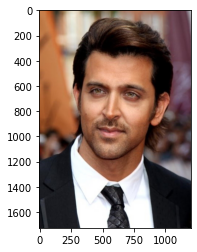

In [35]:
img = Image.open("hr.jpg")
imshow(img)

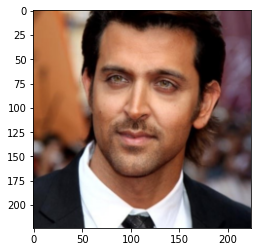

In [37]:
image = transform(img).unsqueeze(0)
imshow(np.transpose(image[0,:,:,:], [1,2,0]))

In [24]:
print(image.shape)

torch.Size([1, 3, 224, 224])


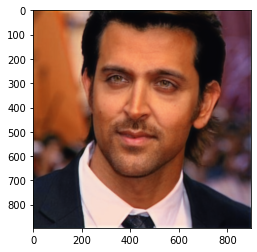

In [38]:
rand_inp = image
ort_inputs = {ort_session.get_inputs()[0].name: rand_inp.detach().numpy()}
ort_outs = ort_session.run(None,ort_inputs)
imshow(np.transpose(ort_outs[0][0,:,:,:], [1,2,0]))